In [1]:
import time
from pathlib import Path


import wandb
import torch as th
import coremltools as ct
import diffusers
from diffusers import StableDiffusionPipeline

In [2]:
print(f"diffusers.version: {diffusers.__version__:>20}\ntorch.verion:      {th.__version__:>20} \ncoreml.version:    {ct.__version__:>20}")

diffusers.version:                0.3.0
torch.verion:        1.13.0.dev20220913 
coreml.version:                   6.0b2


In [3]:
DEVICE = "cpu"

In [4]:
random_seeds = [123, 579957, 478, 19893, 982498]
generators = [th.Generator("cpu").manual_seed(s) for s in random_seeds] 
n_gen = 1

Params

In [5]:
guidance = 7.5
steps = [20]
image_size = 512
height, width = image_size, image_size

In [6]:
model_id = "CompVis/stable-diffusion-v1-4"

prompts = ["discovering ancient ruins, concept art by JaeCheol Park"]
#            "Unicorn on everest summit detailed, concept art by JaeCheol Park",
#            "A futuristic vertical city with ponds and sailbots, concept art by JaeCheol Park",
#            "Olive Farm,  concept art by JaeCheol Park"]

In [7]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True)  # + my auth token

{'trained_betas'} was not found in config. Values will be initialized to default values.


## Let's run default pipeline first!

In [8]:
pipe = pipe.to(DEVICE)

In [ ]:
time.per

In [10]:
for n_steps in steps:
    config= {
      "model":model_id,
      "guidance_scale":guidance,
      "num_inference_steps":n_steps,
      "device": DEVICE,
    }
    wandb.init(project="stable-diffusion", config=config)
    wandb_img_nms=[]
    for n in range(n_gen):
        wandb_img_nms.append(f"image_{n}")

    cols = ['prompt'] + wandb_img_nms + ['guidance_scale', 'num_inference_steps']

    wandb_table = wandb.Table(columns=cols)

    for p in prompts:
        wandb_imgs=[p]

        for n in range(n_gen):
            t = time.perf_counter()
            image = pipe(p, guidance_scale=guidance, num_inference_steps=n_steps,
                         height=height, width=width, generator=generators[n])["sample"][0]
            wandb_imgs.append(wandb.Image(image))
            wandb.log({"sec/step":(time.perf_counter() - t)/n_steps})

        wandb_imgs.append(guidance)
        wandb_imgs.append(n_steps)
        wandb_table.add_data(*wandb_imgs)

    wandb.log({"tables/baseline": wandb_table})
    wandb.finish()

  0%|          | 0/21 [00:00<?, ?it/s]

sec/step,▁
sec/step,4.83363


## MPS PyTorch

In [16]:
DEVICE = "mps"

In [17]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True)  # + my auth token
pipe = pipe.to(DEVICE)

{'trained_betas'} was not found in config. Values will be initialized to default values.


In [18]:
# First-time "warmup" pass (see explanation above)
_ = pipe(prompts[0], num_inference_steps=1)

  0%|          | 0/1 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


In [19]:
for n_steps in steps:
    config= {
      "model":model_id,
      "guidance_scale":guidance,
      "num_inference_steps":n_steps,
      "device": DEVICE,
    }
    wandb.init(project="stable-diffusion", config=config)
   
    wandb_img_nms=[]
    for n in range(n_gen):
        wandb_img_nms.append(f"image_{n}")

    cols = ['prompt'] + wandb_img_nms + ['guidance_scale', 'num_inference_steps']

    wandb_table = wandb.Table(columns=cols)

    for p in prompts:
        wandb_imgs=[p]

        for n in range(n_gen):
            t = time.perf_counter()
            image = pipe(p, guidance_scale=guidance, num_inference_steps=n_steps,
                         height=height, width=width, generator=generators[n])["sample"][0]
            wandb_imgs.append(wandb.Image(image))
            wandb.log({"sec/step":(time.perf_counter() - t)/n_steps})

        wandb_imgs.append(guidance)
        wandb_imgs.append(n_steps)
        wandb_table.add_data(*wandb_imgs)

    wandb.log({"tables/baseline": wandb_table})
    wandb.finish()

  0%|          | 0/21 [00:00<?, ?it/s]

sec/step,▁
sec/step,11.45416


## CoreML optimized Version

loading saved coreml model
loaded


  0%|          | 0/21 [00:00<?, ?it/s]

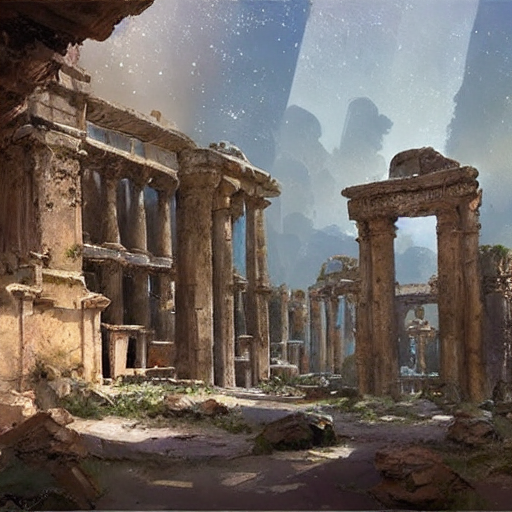

In [5]:
def generate_coreml_model_via_awful_hacks(f, out_name):
    from coremltools.converters.mil import Builder as mb
    from coremltools.converters.mil.frontend.torch.torch_op_registry import register_torch_op, _TORCH_OPS_REGISTRY
    import coremltools.converters.mil.frontend.torch.ops as cml_ops
    def unsliced_attention(self, query, key, value, _sequence_length, _dim):
        attn = (torch.einsum("b i d, b j d -> b i j", query, key) * self.scale).softmax(dim=-1)
        attn = torch.einsum("b i j, b j d -> b i d", attn, value)
        return self.reshape_batch_dim_to_heads(attn)
    diffusers.models.attention.CrossAttention._attention = unsliced_attention
    orig_einsum = th.einsum
    def fake_einsum(a, b, c):
        if a == 'b i d, b j d -> b i j': return th.bmm(b, c.permute(0, 2, 1))
        if a == 'b i j, b j d -> b i d': return th.bmm(b, c)
        raise ValueError(f"unsupported einsum {a} on {b.shape} {c.shape}")
    th.einsum = fake_einsum
    if "broadcast_to" in _TORCH_OPS_REGISTRY: del _TORCH_OPS_REGISTRY["broadcast_to"]
    @register_torch_op
    def broadcast_to(context, node): return cml_ops.expand(context, node)
    if "gelu" in _TORCH_OPS_REGISTRY: del _TORCH_OPS_REGISTRY["gelu"]
    @register_torch_op
    def gelu(context, node): context.add(mb.gelu(x=context[node.inputs[0]], name=node.name))
    class Undictifier(th.nn.Module):
        def __init__(self, m):
            super().__init__()
            self.m = m
        def forward(self, *args, **kwargs): return self.m(*args, **kwargs)["sample"]
    print("tracing")
    f_trace = th.jit.trace(Undictifier(f), (th.zeros(2, 4, 64, 64), th.zeros(1), th.zeros(2, 77, 768)), strict=False, check_trace=False)
    print("converting")
    f_coreml_fp16 = ct.convert(f_trace, 
               inputs=[ct.TensorType(shape=(2, 4, 64, 64)), ct.TensorType(shape=(1,)), ct.TensorType(shape=(2, 77, 768))],
               convert_to="mlprogram",  compute_precision=ct.precision.FLOAT16, skip_model_load=True)
    f_coreml_fp16.save(f"{out_name}")
    th.einsum = orig_einsum
    print("the deed is done")
    
class UNetWrapper:
    def __init__(self, f, out_name="unet.mlpackage"):
        self.in_channels = f.in_channels
        if not Path(out_name).exists():
            print("generating coreml model"); generate_coreml_model_via_awful_hacks(f, out_name); print("saved")
        # not only does ANE take forever to load because it recompiles each time - it then doesn't work!
        # and NSLocalizedDescription = "Error computing NN outputs."; is not helpful... GPU it is
        print("loading saved coreml model"); f_coreml_fp16 = ct.models.MLModel(out_name, compute_units=ct.ComputeUnit.CPU_AND_GPU); print("loaded")
        self.f = f_coreml_fp16
    def __call__(self, sample, timestep, encoder_hidden_states):
        args = {"sample_1": sample.numpy(), "timestep": th.tensor([timestep], dtype=th.int32).numpy(), "input_35": encoder_hidden_states.numpy()}
        for v in self.f.predict(args).values():
            return diffusers.models.unet_2d_condition.UNet2DConditionOutput(sample=th.tensor(v, dtype=th.float32))
pipe.unet = UNetWrapper(pipe.unet)

pipe.safety_checker = lambda images, **kwargs: (images, False)
generator = torch.Generator("cpu").manual_seed(123)
prompt = "discovering ancient ruins, concept art by JaeCheol Park"
image = pipe(prompt, num_inference_steps=20, generator=generator).images[0]
display(image)

  0%|          | 0/32 [00:00<?, ?it/s]

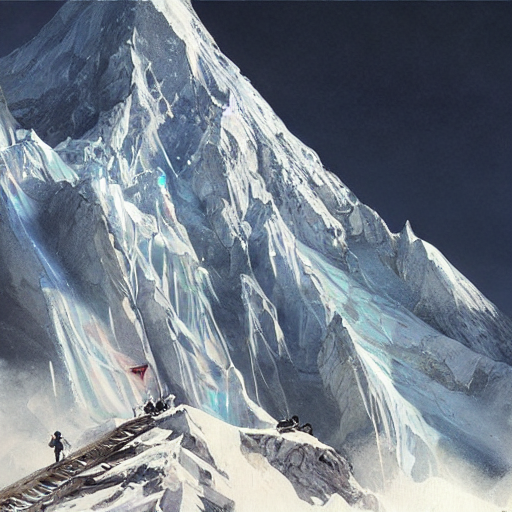

In [12]:
prompt = "Unicorn on everest summit detailed, concept art by JaeCheol Park"
image = pipe(prompt, num_inference_steps=30, generator=generator).images[0]
display(image)

## Text Encoder

In [7]:
class CLIPUndictifier(th.nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, *args, **kwargs): 
        return self.m(*args, **kwargs)[0]

def convert_text_encoder(text_encoder, outname):    
    import transformers
    transformers.models.clip.modeling_clip.CLIPTextTransformer.attention_mask = transformers.models.clip.modeling_clip.CLIPTextTransformer._build_causal_attention_mask(None, 1, 77, th.float)
    def _fake_build_causal_mask(self, *args, **kwargs):
        return self.attention_mask
    transformers.models.clip.modeling_clip.CLIPTextTransformer._build_causal_attention_mask = _fake_build_causal_mask
    f_trace = th.jit.trace(CLIPUndictifier(text_encoder), (th.zeros(1, 77, dtype=th.long)), strict=False, check_trace=False)

    f_coreml = ct.convert(f_trace, 
               inputs=[ct.TensorType(shape=(1, 77))],
               convert_to="mlprogram", compute_precision=ct.precision.FLOAT16, skip_model_load=True)
    f_coreml.save(outname)

class TextEncoderWrapper:
    def __init__(self, f, out_name="text_encoder.mlpackage"):
        if not Path(out_name).exists():
            print("generating coreml model"); convert_text_encoder(f, out_name); print("saved")
        print("loading saved coreml model"); self.f = ct.models.MLModel(out_name, compute_units=ct.ComputeUnit.CPU_AND_GPU); print("loaded")
    
    def __call__(self, input):
        args = args = {"input_ids_1": input.float().numpy()}
        for v in self.f.predict(args).values():
            return (th.tensor(v, dtype=th.float32),)

pipe.text_encoder = TextEncoderWrapper(pipe.text_encoder)

generating coreml model


Running MIL Clean up passes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.32 passes/s]
Exception ignored in: <function MLModel.__del__ at 0x3c53aeaf0>
Traceback (most recent call last):
  File "/Users/tcapelle/miniforge3/envs/dif/lib/python3.9/site-packages/coremltools/models/model.py", line 380, in __del__
    if _shutil is None:
UnboundLocalError: local variable '_shutil' referenced before assignment


saved
loading saved coreml model
loaded


  0%|          | 0/51 [00:00<?, ?it/s]

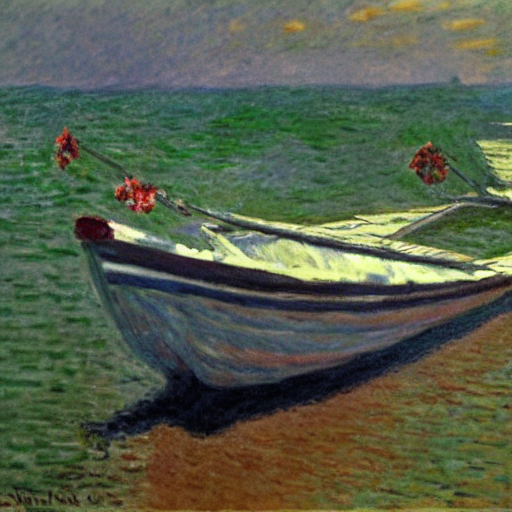

In [8]:
prompt = "A saliboat, concept art by Monet"
image = pipe(prompt, num_inference_steps=50, generator=generator).images[0]
display(image)